<a href="https://colab.research.google.com/github/ProjetVisionParOrdinateur/vo_projet/blob/main/last_Efficiently_Locating_Objects_Using_the_Haudorff_Distance_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, feature
from scipy import ndimage
import math

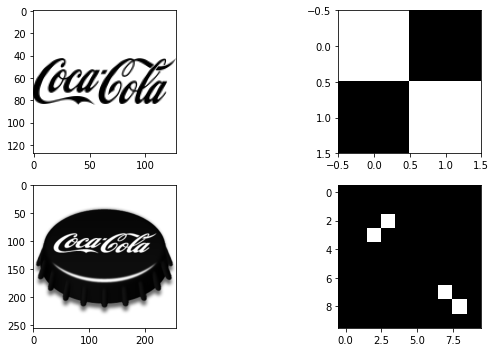

In [24]:
amazon_logo   = io.imread('coca_model.png', as_gray=True)
amazon_center = io.imread('coca_image.png', as_gray=True)

canny_logo = feature.canny(amazon_logo, sigma=2)
canny_center = feature.canny(amazon_center, sigma=2)

canny_logo = np.zeros((2,2))
canny_logo[0,0] = 1
canny_logo[1,1] = 1
canny_center = np.zeros((10,10))
canny_center[7,7] = 1
canny_center[8,8] = 1
canny_center[2,3] = 1
canny_center[3,2] = 1

fig, axs = plt.subplots(2, 2 , figsize=(10, 5))

axs[0,0].imshow(amazon_logo, cmap='gray')
axs[0,1].imshow(canny_logo, cmap='gray')
axs[1,0].imshow(amazon_center, cmap='gray')
axs[1,1].imshow(canny_center, cmap='gray')

fig.tight_layout()
fig.show()

(10, 10)


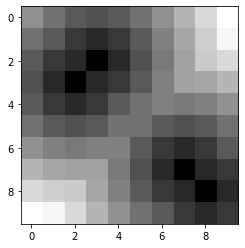

In [25]:
distance_transform_I = ndimage.distance_transform_edt(1 - canny_center)
print(distance_transform_I.shape)

plt.imshow(distance_transform_I, cmap='gray')
plt.show()

In [26]:
def transform(points, a00, a01, a10, a11, tx, ty):
  points_transform = np.zeros(points.shape, dtype=int)
  for i, (x,y) in enumerate(points):
    points_transform[i] = (round(a00*x + a01*y + tx), round(a10*x + a11*y + ty))

  return points_transform

In [27]:
def gen_image_transform(points_transform, xmax, ymax):
  image_transform = np.zeros((xmax, ymax))

  for (x,y) in points_transform:
    x, y = round(x), round(y)
    if 0 <= x and x < image_transform.shape[0] and 0 <= y and y < image_transform.shape[1]:
      image_transform[x, y] = 1

  return image_transform

# Box-Distance Transform
see part 4.2

In [28]:
def delta(x, y, I) :
    return np.linalg.norm([x, y] - I, axis=1).min() # min des i, x et y sont fixes
    

def box_distance_transform(cell, M, I) :
    # calcul top-left & bottom-right corners
    tlc, brc = cell

    w = brc[0] + brc[1] + brc[4] - tlc[0] - tlc[1] - tlc[4] # x-linked dim
    h = brc[2] + brc[3] + brc[5] - tlc[2] - tlc[3] - tlc[5] # y-linked dim
    X, Y = (np.arange(0, w+1), np.arange(0, h+1)) # x', y'

    box_distance = np.zeros(M.shape[0])
    for i in range(M.shape[0]): 
        x, y = M[i] # x, y fixe 
        X_, Y_ = X + x, Y + y # x + x', y + y'
        box_distance[i] = min([delta(x, y, I) for (x, y) in zip(X_, Y_)])
    return box_distance

In [29]:
def box_distance_transform2(cell, M, distance_transform, tof):
    # calcul top-left & bottom-right corners
    tlc, brc = cell

    w = brc[0] + brc[1] + brc[4] - tlc[0] - tlc[1] - tlc[4] # x-linked dim
    h = brc[2] + brc[3] + brc[5] - tlc[2] - tlc[3] - tlc[5] # y-linked dim

    box_distance = np.zeros(M.shape[0])
    for i, (x, y) in enumerate(M): 
      wx = x + w
      wx = wx if wx < distance_transform.shape[0] else w
      hy = y + h
      hy = hy if hy < distance_transform.shape[1] else h
      delta = distance_transform[x:wx+1, y:hy+1]
      if delta.size == 0:
        box_distance[i] = 0
      else:
        box_distance[i] = np.min(delta) <= tof

    return box_distance

In [85]:
import time

#points = liste de tuple 
#M = image model 1 = point interêt / 0 sinon
#I = image 1 = point interêt / 0 sinon
def localisation(M, I, tof, tor, ff, fr, d_min, d_max, alpha_max, s_max):
  r = 2

  distance_transform_I = ndimage.distance_transform_edt(1 - I)

  M_points_interet = np.array(list(zip(*np.nonzero(M))))

  cell_size_start = max(I.shape[0], I.shape[1])
  cell_size_start = cell_size_start if cell_size_start % 2 == 0 else cell_size_start + 1

  cells = [(np.zeros(6, dtype=int), np.full(6, cell_size_start, dtype=int))]

  base = np.array([1/I.shape[0], 1/I.shape[0], 1/I.shape[1], 1/I.shape[1], 1, 1])

  transforms = []

  while(cells != []):
    cell = cells[0]
    tlc, brc = cell
    box_distance = box_distance_transform2(cell, transform(M_points_interet, *(tlc * base)), distance_transform_I, tof)
    if np.count_nonzero(box_distance) / M.shape[0] >= ff:
      #cellule intéréssante
      finer_cell_size = (brc - tlc) // r
      if not np.any(finer_cell_size > 0):
        transforms.append(tlc)
      else:
        for a00 in range(r):
          for a01 in range(r):
            for a10 in range(r):
              for a11 in range(r):
                for tx in range(r):
                  for ty in range(r):
                    finer_cell_tlc = np.array([tlc[0] + a00 * finer_cell_size[0], 
                                              tlc[1] + a01 * finer_cell_size[1],
                                              tlc[2] + a10 * finer_cell_size[2],
                                              tlc[3] + a11 * finer_cell_size[3],
                                              tlc[4] + tx * finer_cell_size[4],
                                              tlc[5] + ty * finer_cell_size[5]])
                    cells.append((finer_cell_tlc, finer_cell_tlc + finer_cell_size))
    del cells[0]

  i = 0
  while i < len(transforms):
    trans = transforms[i] * base

    d = trans[0] * trans[3] - trans[1] * trans[2] 
    if d < d_min or d > d_max:
      del transforms[i]
      continue

    d_a00_a01 = np.sqrt(trans[0]*trans[0] + trans[2]*trans[2])
    d_a01_a11 = np.sqrt(trans[1]*trans[1] + trans[3]*trans[3])
    alpha = max(d_a00_a01/d_a01_a11, d_a01_a11/d_a00_a01)
    s = abs(trans[0]*trans[1]+trans[2]*trans[3]) / (d_a00_a01*d_a01_a11)
    if alpha > alpha_max or s > s_max:
      del transforms[i]
      continue
    
    i+=1

  

  return transforms

In [34]:
xmax, ymax = canny_center.shape[0], canny_center.shape[1]

tof = np.sqrt(5)

M = np.array(list(zip(*np.nonzero(canny_logo))))
print(M.shape)

I = np.array(list(zip(*np.nonzero(canny_center))))

cells = [(np.array([0,0,0,0,0,0]), np.array([xmax, xmax, ymax, ymax, xmax, ymax]))]

start = time.time()
box_distance = box_distance_transform2(cells[0], M, distance_transform_I, tof)
count = np.count_nonzero(box_distance)

print(time.time() - start)

print(count / M.shape[0])
print(np.unique(box_distance))

r = 2

(2, 2)
0.0008313655853271484
1.0
[1.]


In [87]:
tof = tor = 0
ff = 1
fr = 0.8
d_min = 0.3
d_max = 1
alpha_max = 2 
s_max = 1

transforms = localisation(canny_logo, canny_center, tof, tor, ff, fr, d_min, d_max, alpha_max, s_max)

[array([5, 0, 0, 6, 0, 0]), array([5, 0, 0, 6, 0, 1]), array([5, 0, 0, 6, 1, 0]), array([5, 0, 0, 6, 1, 1]), array([5, 0, 1, 6, 0, 0]), array([5, 0, 1, 6, 0, 1]), array([5, 0, 1, 6, 1, 0]), array([5, 0, 1, 6, 1, 1]), array([5, 1, 0, 6, 0, 0]), array([5, 1, 0, 6, 0, 1]), array([5, 1, 0, 6, 1, 0]), array([5, 1, 0, 6, 1, 1]), array([6, 0, 0, 5, 0, 0]), array([6, 0, 0, 5, 0, 1]), array([6, 0, 0, 5, 1, 0]), array([6, 0, 0, 5, 1, 1]), array([6, 0, 0, 6, 0, 0]), array([6, 0, 0, 6, 0, 1]), array([6, 0, 0, 6, 1, 0]), array([6, 0, 0, 6, 1, 1]), array([6, 0, 1, 5, 0, 0]), array([6, 0, 1, 5, 0, 1]), array([6, 0, 1, 5, 1, 0]), array([6, 0, 1, 5, 1, 1]), array([6, 0, 1, 6, 0, 0]), array([6, 0, 1, 6, 0, 1]), array([6, 0, 1, 6, 1, 0]), array([6, 0, 1, 6, 1, 1]), array([6, 1, 0, 5, 0, 0]), array([6, 1, 0, 5, 0, 1]), array([6, 1, 0, 5, 1, 0]), array([6, 1, 0, 5, 1, 1]), array([6, 1, 0, 6, 0, 0]), array([6, 1, 0, 6, 0, 1]), array([6, 1, 0, 6, 1, 0]), array([6, 1, 0, 6, 1, 1]), array([6, 1, 1, 6, 0, 0]), 

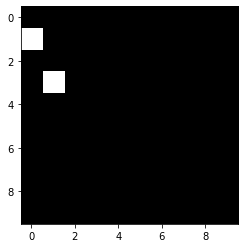

In [129]:
print(transforms)

xmax, ymax = canny_center.shape[0], canny_center.shape[1]

base = np.array([1/xmax, 1/xmax, 1/ymax, 1/ymax, 1, 1])

idx = 3854
trans = transforms[idx]
print(trans)
points_transform = transform(M, *(trans * base))

image_test = gen_image_transform(points_transform, canny_center.shape[0], canny_center.shape[1])

plt.imshow(image_test, cmap='gray')
plt.show()

# Distance de Haursdorff

In [ ]:
def Haursdorff(model, image, ff, fr, tof, tor) :
  # 1 - partial forward Hausdorff distance.
  # Cell-division <=> a cell must satisfy the forward criterion f[t] >= ff   
  ### hff = todo
  # 2 - partial box-reverse Hausdorff distance
  ### hfrbox = todo
  # 3 - Hausdorff distance
  # return max(hff, hfrbox)
  pass

In [12]:
cells = [(np.zeros(3, dtype=int), np.full(3, 4, dtype=int))]

r = 2

res = []

while cells != []:
  print(cells)
  tlc, brc = cells[0]
  finer_cell_size = (brc - tlc) // r
  if not np.any(finer_cell_size > 0):
    res.append(tlc)
    res.append(brc)
  else:
    for x in range(r):
      for y in range(r):
        for z in range(r):
          finer_cell_tlc = np.array([tlc[0] + x * finer_cell_size[0], 
                                    tlc[1] + y * finer_cell_size[1],
                                    tlc[2] + z * finer_cell_size[2]])
          cells.append((finer_cell_tlc, finer_cell_tlc + finer_cell_size))
  del cells[0]


[(array([0, 0, 0]), array([4, 4, 4]))]
[(array([0, 0, 0]), array([2, 2, 2])), (array([0, 0, 2]), array([2, 2, 4])), (array([0, 2, 0]), array([2, 4, 2])), (array([0, 2, 2]), array([2, 4, 4])), (array([2, 0, 0]), array([4, 2, 2])), (array([2, 0, 2]), array([4, 2, 4])), (array([2, 2, 0]), array([4, 4, 2])), (array([2, 2, 2]), array([4, 4, 4]))]
[(array([0, 0, 2]), array([2, 2, 4])), (array([0, 2, 0]), array([2, 4, 2])), (array([0, 2, 2]), array([2, 4, 4])), (array([2, 0, 0]), array([4, 2, 2])), (array([2, 0, 2]), array([4, 2, 4])), (array([2, 2, 0]), array([4, 4, 2])), (array([2, 2, 2]), array([4, 4, 4])), (array([0, 0, 0]), array([1, 1, 1])), (array([0, 0, 1]), array([1, 1, 2])), (array([0, 1, 0]), array([1, 2, 1])), (array([0, 1, 1]), array([1, 2, 2])), (array([1, 0, 0]), array([2, 1, 1])), (array([1, 0, 1]), array([2, 1, 2])), (array([1, 1, 0]), array([2, 2, 1])), (array([1, 1, 1]), array([2, 2, 2]))]
[(array([0, 2, 0]), array([2, 4, 2])), (array([0, 2, 2]), array([2, 4, 4])), (array([